# 1. Generating

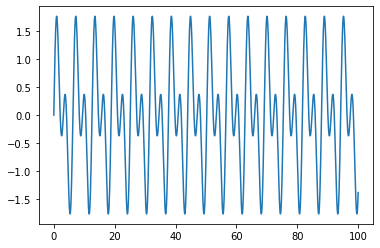

In [150]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

# ====== Generating Dataset ====== #
num_data = 2400
t = np.linspace(0.0, 100.0, num_data)
y = np.sin(t) + np.sin(2*t)
e = np.random.normal(0, 0.1, num_data)
# print(y.shape, e.shape)         # (101,) (2400,)
# y = y + e

plt.plot(t,y)

seq_len = 10
X = []
y_true = []
for i in range(len(t)-seq_len):
    X.append(y[i:i+seq_len])
    y_true.append(y[i+seq_len])

X = np.array(X)
y_true = np.array(y_true)

# [seq_len, batch_size, input_dim] = [10, 2390, 1] --> 이 순서로 모양을 만들어야함
# print(y.shape)                # (2390,)
# print(X.shape)                # (2390, 10)

X = np.swapaxes(X, 0, 1)        # shape을 바꾸기 위해 axes의 순서를 바꿔줌
# print(X.shape)                # (10, 2390)
X = np.expand_dims(X, axis=2)
# print(X.shape)                # (10, 2390, 1), 초반에 만들려고 했던 shape 만들기 완성

#2. Define Model(Many to one)

In [147]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_dim, output_dim, hid_dim, batch_size): 
        super(RNN, self).__init__()

        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hid_dim = hid_dim
        self.batch_size = batch_size

        # RNN 기본 원리를 설명하는 그림을 보면서 구현중
        self.u = nn.Linear(self.input_dim, self.hid_dim, bias=False)
        self.w = nn.Linear(self.hid_dim, self.hid_dim, bias=False)
        self.v = nn.Linear(self.hid_dim, self.output_dim, bias=False)
        self.act = nn.Tanh()

        self.hidden = self.init_hidden()

    def init_hidden(self, batch_size=None):
        if batch_size is None:
            batch_size = self.batch_size
        return torch.zeros(batch_size, self.hid_dim)

    
    def forward(self, x):
        # print(self.hidden[0])
        h = self.act(self.u(x) + self.w(self.hidden))
        y = self.v(h)
        self.hidden = h

        return y, h

In [151]:
import torch.optim as optim

model = RNN(1, 1, 50, 2390)
# print(X.shape)              # (10, 2390, 1)
# print(model.hidden)             # 첫번째 hidden이 '0'으로 초기화가 된 것을 확인가능

loss_fn = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr = 0.01)
epoch = 30


### Train
for i in range(epoch):
    model.train()
    model.zero_grad()
    optimizer.zero_grad()

    model.hidden = model.init_hidden()  # Error 02 해결: model에서 초반에 'self.hidden = self.init_hidden()'으로 설정했는데, 두 번째 epoch에서 다시 hidden은 0으로 시작해야하므로 초기화를 할 수 있는 부분을 추가해야함

    for x in X:                 # hidden이 잘 업데이트 됬는지 확인해 보기
        x = torch.Tensor(x).float()
        y_true = torch.Tensor(y_true).float()

        y_pred, hidden = model(x)
        model.hidden = hidden

        # Error 01: loss.py:528: UserWarning: Using a target size (torch.Size([2390])) that is different to the input size (torch.Size([2390, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size. return F.mse_loss(input, target, reduction=self.reduction)
        # print(y_pred.shape, y_true.shape)       # torch.Size([2390, 1]) torch.Size([2390]), 차원이 안 맞다고 에러 뜨면 무조건 shape로 차원을 시각적으로 확인하는 습관가지기
        # print(y.shape)          # torch.Size([2390, 1])

    loss = loss_fn(y_pred.view(-1), y_true.view(-1))     # Error 01 해결: view를 통해 차원을 맞춰줌
    # 1:03:01 >> Error 02: RuntimeError: Trying to backward through the graph a second time (or directly access saved variables after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved variables after calling backward.
    # zero gradient가 제대로 들어가지 않았다는 의미
    loss.backward()
    optimizer.step()
    print(loss.item())      # 줄어드는 loss 확인


0.9874444007873535
0.5767064690589905
0.34237661957740784
0.2098768800497055
0.13565291464328766
0.09434473514556885
0.07138247787952423
0.0585285983979702
0.0511951744556427
0.046858929097652435
0.04414574056863785
0.04231272265315056
0.04096025228500366
0.039874061942100525
0.03893936797976494
0.0380946509540081
0.03730682283639908
0.03655795753002167
0.03583821654319763
0.035142071545124054
0.034466300159692764
0.03380894660949707
0.03316870704293251
0.03254462778568268
0.03193600848317146
0.03134223073720932
0.03076276183128357
0.03019712120294571
0.029644852504134178
0.029105527326464653


(0.0, 50.0)

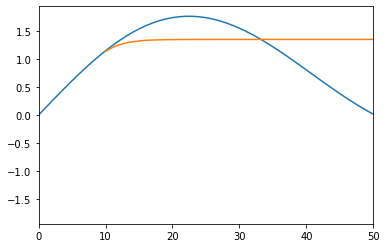

In [154]:
### validation
# print(X.shape)
test_X = np.expand_dims(X[:, 0, :], 1)
# print(test_X.shape)

list_y_pred = []

model.eval()
with torch.no_grad():
    model.hidden = model.init_hidden(batch_size=1)

    for x in test_X:                
        x = torch.Tensor(x).float()
        y_pred, hidden = model(x)
        model.hidden = hidden
    list_y_pred.append(y_pred.view(-1).item())

    # print(y_pred.shape, x.shape)        # torch.Size([2390, 1]) torch.Size([1, 1]), batch_size를 따로 정의해서 차원을 맞춰줘야함. model 부분에서 batch_size를 None으로 초기화해서 조건을 추가함. ==> torch.Size([1, 1]) torch.Size([1, 1])


    temp_X = list()
    temp_X += test_X
    for i in range(2389):
        y_pred, hidden = model(y_pred)
        list_y_pred.append(y_pred.view(-1).item())

        for x in temp_X:
            y_pred, hidden = model(x)
            model.hidden = hidden
        list_y_pred.append(y_pred.view(-1).item())

    # print(len(list_y_pred))         # 2390

plt.plot(y)
plt.plot(list(range(10, 2400)),list_y_pred)
plt.xlim(0,50)